<a href="https://colab.research.google.com/github/Polyakri/projects/blob/main/MachineLearningProjects/RockPaperScissors_Game/5_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing necessary Libraries

In [42]:
#!pip install ipywidgets

import numpy as np
import pandas as pd
import tensorflow as tf
import os
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
from ast import literal_eval
import random
import time
from sklearn.metrics import accuracy_score
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading the data

Train the CNN

The agent I chose has 99.5% accuracy

In [2]:
CNN_results = pd.read_csv('drive/MyDrive/MLFinalEx/Results/CNN_fully_flipped.csv')

best_accuracy_row = CNN_results[CNN_results['Accuracy'] == CNN_results['Accuracy'].max()]

num_conv_layers = best_accuracy_row['Num_Conv_Layers'].values[0]
num_filters = best_accuracy_row['Num_Filters'].values[0]
kernel_size = best_accuracy_row['Kernel_Size'].values[0]
kernel_size = literal_eval(kernel_size)
hidden_layers = best_accuracy_row['MLP_Num_Hidden_Layers'].values[0]
units_per_layer = best_accuracy_row['MLP_Units_Per_Layer'].values[0]
activation  = best_accuracy_row['Activation'].values[0]
dropout = best_accuracy_row['Dropout_Rate'].values[0]
batch_size  = best_accuracy_row['Batch_Size'].values[0]
epochs = best_accuracy_row['Epochs'].values[0]
learning_rate = best_accuracy_row['Learning_Rate'].values[0]
output_activation  = best_accuracy_row['Output_Activation'].values[0]

x_data_ff = np.load('drive/MyDrive/MLFinalEx/NoPCA/x_data_full_flipped.npy')
y_data_ff = np.load('drive/MyDrive/MLFinalEx/NoPCA/y_data_full_flipped.npy')

x_data_ff = np.reshape (x_data_ff, (x_data_ff.shape[0],200,300,1))

target_size = (75, 50)

# Create an empty array to store resized images
resized_images = np.empty((x_data_ff.shape[0], target_size[1], target_size[0]))

# Loop through each image and resize
for i in range(x_data_ff.shape[0]):
    img = x_data_ff[i]

    # Resize the image using OpenCV
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

    # Store the resized image in the new array
    resized_images[i] = resized_img

x_data_ff = resized_images

x_train, x_test, y_train, y_test = train_test_split(
    x_data_ff, y_data_ff, test_size=0.2, random_state=42, stratify=y_data_ff
)

metrics = ['accuracy']
loss = 'binary_crossentropy'
num_classes =3
strides = (1, 1)
y_test = tf.one_hot(y_test, depth=num_classes)
y_train = tf.one_hot(y_train, depth=num_classes)

print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)


cnn = tf.keras.Sequential(name='my-cnn')
cnn.add(tf.keras.layers.Input((50, 75, 1), name='input_layer'))

for i in range(num_conv_layers):
  cnn.add(tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, strides=strides, activation=activation,
                                       name=f'conv_layer{i + 1}'))
  cnn.add(tf.keras.layers.Dropout(rate=dropout, name=f'dropout_{i + 1}'))
  cnn.add(tf.keras.layers.MaxPooling2D(name=f'maxpool_{i + 1}'))

    # Flattening
cnn.add(tf.keras.layers.Flatten())

    # MLP
for i in range(hidden_layers):
  cnn.add(tf.keras.layers.Dense(units=units_per_layer, activation=activation, name=f'hidden_layer_{i + 1}'))

cnn.add(tf.keras.layers.Dense(units=num_classes, activation=output_activation, name='output_layer'))

cnn.summary ()

cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
                metrics=['accuracy'])

history = cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=1)

accuracy = history.history['val_accuracy'][-1]

accuracy

y_train.shape: (3500, 3)
y_test.shape: (876, 3)
Model: "my-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 46, 71, 32)        832       
                                                                 
 dropout_1 (Dropout)         (None, 46, 71, 32)        0         
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 23, 35, 32)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 19, 31, 32)        25632     
                                                                 
 dropout_2 (Dropout)         (None, 19, 31, 32)        0         
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 9, 15, 32)         0         
                                                                 
 conv_layer3

0.9920091032981873

Predict my images

#Prepare the opponent

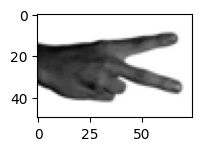

scissor


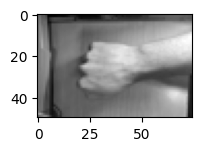

rock


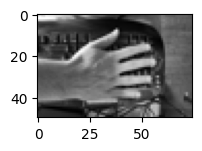

paper


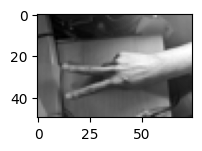

scissor


In [46]:
def predict_gesture(image_path, cnn_model):
    # Open the image using PIL
    img = Image.open(image_path)

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Convert the image to grayscale
    gray_img = img.convert('L')

    # Resize the image to 50x75
    resized_img = gray_img.resize((75, 50))

    # Convert the resized image to a NumPy array
    resized_array = np.array(resized_img)

    # Display the shape of the resized array
    plt.figure(figsize=(2, 3))  # Adjust the figure size as needed
    plt.imshow(resized_array, cmap='gray')
    plt.show()

    # Flip the image horizontally and vertically
    resized_array = cv2.flip(resized_array, 1)
    resized_array = cv2.flip(resized_array, 0)

    # Normalize the pixel values to be between 0 and 1
    resized_array = resized_array / 255

    # Reshape the array to match the model input shape
    resized_array = resized_array.reshape(1, 50, 75, 1)

    # Make the prediction using the provided CNN model
    prediction = cnn_model.predict(resized_array, verbose=0)

    # Get the index of the maximum predicted value
    max_index = np.argmax(prediction)

    # Map the index to the corresponding gesture
    if max_index == 0:
        result = "rock"
    elif max_index == 1:
        result = "paper"
    elif max_index == 2:
        result = "scissor"

    print(result)


predict_gesture ('drive/MyDrive/test_image.png', cnn)
predict_gesture ( 'drive/MyDrive/my_test2.png', cnn)
predict_gesture ( 'drive/MyDrive/my_test3.png', cnn)
predict_gesture ( 'drive/MyDrive/my_test4.png', cnn)



In [43]:
x_data = np.load('drive/MyDrive/MLFinalEx/NoPCA/x_data_original.npy')
y_data = np.load('drive/MyDrive/MLFinalEx/NoPCA/y_data_original.npy')

x_data = np.reshape (x_data, (x_data.shape[0],200,300,1))
x_data.shape

(2188, 200, 300, 1)

For 65.0 repeats with 0.1% noise


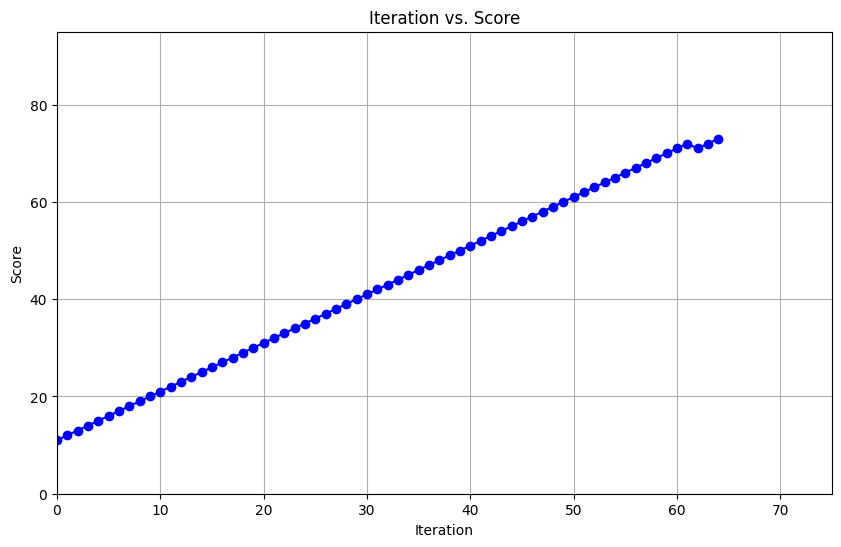

In [94]:
target_size = (75, 50)

start = widgets.Button(description="start")
clear =widgets.Button(description="clear")
percentage_slider = widgets.FloatSlider(
    value=50,  # Initial value
    min=0,     # Minimum value
    max=0.1,   # Maximum value
    step=.01,    # Step size
    description='Noise Standard Deviation:'
)

iterations_slider = widgets.FloatSlider(
    value=50,  # Initial value
    min=1,     # Minimum value
    max=200,   # Maximum value
    step=1,    # Step size
    description='Number of iterations:'
)

checkbox = widgets.Checkbox(
    value=False,
    description='Show Images'
)


def on_clear_button_click(b):
    clear_output(wait=False)
    display(widgets.VBox([percentage_slider, iterations_slider, checkbox, start, clear]))

def on_button_click(b):
    score = 10
    iteration_list = []
    score_list = []

    print(f"For {iterations_slider.value} repeats with {percentage_slider.value}% noise")
    correct_predictions = 0

    for _ in range(int(iterations_slider.value)):
        j = np.random.randint(1, 5)
        i = np.random.randint(len(x_data))  # Choose a random index from the dataset
        normalized_image = x_data[i]
        label = y_data[i]

        mean = 0
        stddev = percentage_slider.value
        gaussian_noise = np.random.normal(mean, stddev, normalized_image.shape)
        noisy_image = gaussian_noise + normalized_image

        if j == 1:
            pass
        elif j == 2:
            noisy_image = cv2.flip(noisy_image, 1)
        elif j == 3:
            noisy_image = cv2.flip(noisy_image, 0)
        elif j == 4:
            noisy_image = cv2.flip(noisy_image, 1)
            noisy_image = cv2.flip(noisy_image, 0)
        else:
            print(j)
            raise ValueError("Invalid value.")

        if checkbox.value:
            plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
            plt.subplot(1, 2, 1)
            plt.title(f'Original Image - Label: {label}')
            plt.imshow(normalized_image, cmap='gray')
            plt.subplot(1, 2, 2)
            plt.title('Noisy Image')
            plt.imshow(noisy_image, cmap='gray')
            plt.show()

        noisy_image = cv2.resize(noisy_image, target_size, interpolation=cv2.INTER_AREA)
        noisy_image = noisy_image.reshape(1, 50, 75, 1)

        # Get the CNN prediction
        # Assuming cnn is defined somewhere in your code
        prediction = cnn.predict(noisy_image, verbose=0)
        max_index = np.argmax(prediction)

        # Assign the corresponding value based on the index
        if max_index == 0:
            result = "rock"
        elif max_index == 1:
            result = "paper"
        elif max_index == 2:
            result = "scissor"
        if checkbox.value:
            print(result)

        if max_index == label:
            score += 1
        else:
            score -= 1

        iteration_list.append(_)
        score_list.append(score)

    # Plot outside the loop
    plt.figure(figsize=(10, 6))
    plt.plot(iteration_list, score_list, marker='o', linestyle='-', color='b')
    plt.title('Iteration vs. Score')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.grid(True)

    plt.xlim(left=0, right=iterations_slider.value + 10)
    plt.ylim(0, top=30 + iterations_slider.value)
    plt.show()

# Assuming cnn is defined somewhere in your code
start.on_click(on_button_click)
clear.on_click(on_clear_button_click)
widgets.VBox([percentage_slider, iterations_slider, checkbox, start, clear])

In [72]:
def loading_bar():
    duration = 1  # Duration of the loading bar in seconds
    dots = 10  # Number of dots in the loading bar

    print("Loading", end='', flush=True)

    for _ in range(dots):
        time.sleep(duration / dots)
        print(".", end='', flush=True)

def on_clear_button_click(b):
    clear_output(wait=False)

    # Hide the images by redisplaying only the buttons and slider
    display(Rock, Paper, Scissor, percentage_slider, clear_button, log_output)

def on_button_click(b):
    print(f"Button {b.description} clicked with {percentage_slider.value}%")
    if(b.description=='Rock'):
      labelp =0
    elif (b.description=='Paper'):
      labelp =1
    elif (b.description=='Scissor'):
      labelp=2

    indices = np.where(y_data == labelp)[0]
    j =np.random.randint(1, 5)
    random_index = np.random.choice(indices)

    normalized_image = x_data[random_index]
    label = y_data[random_index]

    mean = 0
    stddev = percentage_slider.value
    gaussian_noise = np.random.normal(mean, stddev, normalized_image.shape)
    image = gaussian_noise+normalized_image

    image = np.clip(image, 0, 1)
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)



    plt.show()
    if(j==1):
      pass
    elif(j==2):
      image = cv2.flip(image, 1)
    elif(j==3):
      image =  cv2.flip(image, 0)
    elif(j==4):
      image = cv2.flip(image, 1)
      image = cv2.flip(image, 0)
    else:
      print (j)
      raise ValueError("Invalid value.")

    plt.figure(figsize=(4, 6))  # Adjust the figure size as needed
    plt.subplot(1, 2, 1)
    plt.title(f'Original Image - Label: {label}')
    plt.imshow(normalized_image, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title('Noisy Image')
    plt.imshow(image, cmap='gray')
    plt.show()
    # Add the noise to the image

    image = image.reshape(1, 50, 75, 1)
    print ("So this is your choice? Let me think...")
    loading_bar()


    prediction = cnn.predict(image, verbose = 0)
    max_index = np.argmax(prediction)
    if max_index == 0:
      result = "rock"
      pick_label = 1
      pick ="paper"
    elif max_index == 1:
      result = "paper"
      pick_label = 2
      pick ="scissor"
    elif max_index == 2:
      result = "scissor"
      pick_label = 0
      pick ="rock"


    print(f'Ha it is easy.... I choose:')
    pick_index = np.where(y_data == pick_label)[0]
    random_index = np.random.choice(pick_index)
    normalized_image = x_data[random_index]
    plt.figure(figsize=(2,3))  # Adjust the figure size as needed
    plt.imshow(normalized_image, cmap='gray')
    plt.show()
    print(pick)
    time.sleep(2)
    if(max_index ==labelp ):
      print("Too easy.... You cannot win me...")
    else:
      print("What?!?!?! I lost?? IMPOSSIBLE")




# Create buttons
Rock = widgets.Button(description="Rock")
Paper = widgets.Button(description="Paper")
Scissor = widgets.Button(description="Scissor")
clear_button = widgets.Button(description="Clear Log")

percentage_slider = widgets.FloatSlider(
    value=50,  # Initial value
    min=0,     # Minimum value
    max=0.1,   # Maximum value
    step=.01,    # Step size
    description='Percentage:'
)

# Assign the same callback function to all buttons
Rock.on_click(on_button_click)
Paper.on_click(on_button_click)
Scissor.on_click(on_button_click)
log_output = widgets.Output()
clear_button.on_click(on_clear_button_click)

# Display buttons
display(Rock, Paper, Scissor, percentage_slider, clear_button, log_output)

Button(description='Rock', style=ButtonStyle())

Button(description='Paper', style=ButtonStyle())

Button(description='Scissor', style=ButtonStyle())

FloatSlider(value=0.1, description='Percentage:', max=0.1, step=0.01)

Button(description='Clear Log', style=ButtonStyle())

Output()